In [6]:
import gaps_online as go
import gaps_online.db as db
import re
from glob import glob
import numpy as np
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import scipy.optimize
from scipy.stats import chi2

In [7]:
def fit_sine(nanoseconds, volts):
    tt = np.array(nanoseconds)
    yy = np.array(volts)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt

    phase_multiple_pi = p / np.pi

    # Calculate R-squared
    residuals = yy - sinfunc(tt, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((yy - np.mean(yy))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Calculate expected values from the fitted sine curve
    expected_values = sinfunc(tt, *popt)
    
    # Calculate observed frequencies
    observed_values, _ = np.histogram(yy, bins=len(tt))
    
    # Calculate chi-squared statistic
    chi_squared_stat = np.sum((observed_values - expected_values)**2 / expected_values)
    
    # Determine degrees of freedom
    df = len(tt) - len(popt)

    reduced_chi_squared = chi_squared_stat / df
    
    # Calculate p-value using chi-square distribution
    p_value = 1 - chi2.cdf(chi_squared_stat, df)
    
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": f"{A:.2f}", "omega": f"{w:.2f}", "phase" : f"{p: .2f}", "phase_formatted": f"{phase_multiple_pi:.2f}π", "offset": f"{c:.2f}", "freq": f"{f:.2f}", "period": f"{1./f:.2f}", "fitfunc": fitfunc, "maxcov": f"{np.max(pcov):.2f}", "rawres": (guess,popt,pcov), "r_squared": f"{r_squared:.2f}", "chi_squared_stat": f"{chi_squared_stat:.2f}",
            "p_value": f"{p_value:.2f}", 'reduced_chi_squared': f"{reduced_chi_squared:.2f}"}


In [3]:
calib = go.tof.calibrations.load_calibrations(Path('/data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/20240305/'))

if len(calib.keys()) != 40: 
    missing = 40 -len(calib.keys())
    print(f'Oh no! {missing} calibrations are missing :(')
else: print('Yay! All calibration files were loaded :)')

Loading calibration files:  24%|█████████████████████████████████▏                                                                                                      | 10/41 [00:04<00:11,  2.63it/s]

Failed to get RB ID from file /data1/nextcloud/cra_data/data/2023_nevis/tof/calibration/20240305/Run122_1.2024_03_05-21_24_51.tof.gaps


Loading calibration files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:17<00:00,  2.39it/s]

Yay! All calibration files were loaded :)


In [133]:
fixed_path = "/data1/nextcloud/cra_data/data/2023_nevis/tof/142/Run142"

files = glob(f'{fixed_path}_*.tof.gaps')

data = go.tof.get_tofpackets(test_file, filter=go.cxx_api.PacketType.TofEvent)
evts = [go.cxx_api.TofEvent.from_tofpacket(k) for k in data]

print(len(files[:10]))

10


In [134]:
ch9_hits = []
ch9_hits_dict = defaultdict(list)

betas = []
phases = {}
for file in files[:10]:
    for ev in tqdm(evts):
        rbids = ev.get_rbids()
        id = ev.header.event_id
        if not any(rb_id in rbids for rb_id in (15, 16)):
            continue 
        for event_id in (ev.get_rbevent(k) for k in rbids):
            
            if event_id.header.rb_id == 0:
                continue 
            key = event_id.header.rb_id
            if len(str(key)) > 2:
                continue  # error where some ids are in the hundreds
            try:
                calibration = calib[key]
            except KeyError:
                continue
            tt = np.linspace(0, 500, 1024)
            voltage_calib = calibration.voltages(event_id)
            ch9_voltages = voltage_calib[8]
            
            res = fit_sine(tt, ch9_voltages)
            phase = float(res['phase'])
            omega = float(res['omega'])
            phase_shift = phase / omega
            phases[event_id.header.rb_id] = abs(phase_shift)
            
            if phase_shift < 0:
                phase_shift = -phase_shift
            for h in event_id.hits:
                if h.paddle_id not in (6, 66):
                    continue
                x_position = h.x_pos
                t_avg = h.t_avg
                info = {'event_id' : id, 'paddle_id' : h.paddle_id, 'x_position': x_position, 't_avg': t_avg, 'phase_shift': phase_shift}
                ch9_hits.append(info)

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

  0%|          | 0/49122 [00:00<?, ?it/s]

In [136]:
for element in tqdm(ch9_hits):
    event_id = element['event_id']
    paddle_id = element['paddle_id']
    x_position = element['x_position']
    t_avg = element['t_avg']
    phase_shift = element['phase_shift']

    # Check if the event ID already exists in the dictionary
    if event_id in ch9_hits_dict:
        # If yes, check if the paddle ID already exists for this event ID
        if paddle_id in ch9_hits_dict[event_id]:
            # If yes, append the data to the existing list for the paddle ID
            ch9_hits_dict[event_id][paddle_id].append({'x_position': x_position, 't_avg': t_avg, 'phase_shift': phase_shift})
        else:
            # If no, create a new entry for the paddle ID with a list containing the data
            ch9_hits_dict[event_id][paddle_id] = [{'x_position': x_position, 't_avg': t_avg, 'phase_shift': phase_shift}]
    else:
        # If the event ID doesn't exist, create a new entry for it with the paddle ID
        ch9_hits_dict[event_id] = {paddle_id: [{'x_position': x_position, 't_avg': t_avg, 'phase_shift': phase_shift}]}

# # # Now print the paddle IDs
# for event_id, paddle_data in ch9_hits_dict.items():
#     # Print the event ID
#     print("Event ID:", event_id)
#     # Iterate over the keys (paddle IDs) in the inner dictionary
#     for paddle_id in paddle_data.keys():
#         # Print each paddle ID
#         print("Paddle ID:", paddle_id)


  0%|          | 0/79590 [00:00<?, ?it/s]

In [137]:
betas = []
time_diff_dist = []

for event_id, paddle_data in ch9_hits_dict.items():
    paddle_66_loc = 1989 
    paddle_66_cblen = 2950 / 1000
    paddle_6_loc = 1287
    paddle_6_cblen = 3750 / 1000

    delta_loc = paddle_66_loc - paddle_6_loc
    ratio_cblen = paddle_66_cblen / paddle_6_cblen
    if len(paddle_data) != 2: continue
    
    for paddle_id, data_list in paddle_data.items(): 
       
        if paddle_id == 66:
            for data in data_list:
                x_pos_66 = data['x_position']
                time_paddle_66 = data['t_avg']
                phase_shift_66 = data['phase_shift']
        elif paddle_id == 6:
            for data in data_list:
                time_paddle_6 = data['t_avg']
                x_pos_6 = data['x_position']
                phase_shift_6 = data['phase_shift']

        time_paddle_6 -= phase_shift_6
        time_paddle_66 -= phase_shift_66

        absolute_time = (time_paddle_6 - time_paddle_66) /(10**9)  # seconds
        absolute_x_diff = abs(x_pos_6 - x_pos_66) / (100)  # m
        cblen_diff = (paddle_6_cblen - paddle_66_cblen ) / 1000
        hypotenuse = np.sqrt((absolute_x_diff)**2 + (cblen_diff)**2) #mm
        time_diff_dist.append(absolute_time)
        
        beta = hypotenuse / absolute_time 
        beta = beta / scipy.constants.c
        beta_str = "{:.3e}".format(beta)
        betas.append(beta_str) 


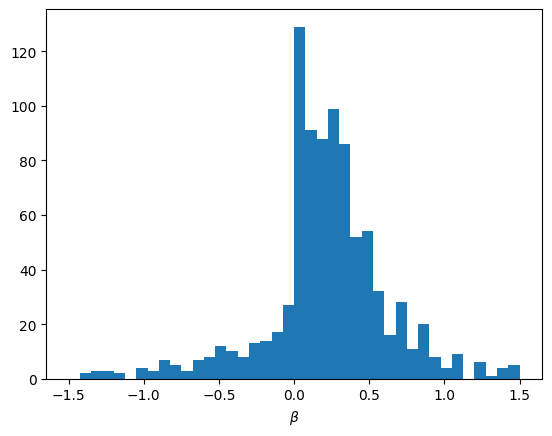

In [138]:
betas = [float(b) for b in betas]

plt.hist(betas, bins = 40, range = (-1.5,1.5))
plt.xlabel(r'$\beta$')
plt.show()

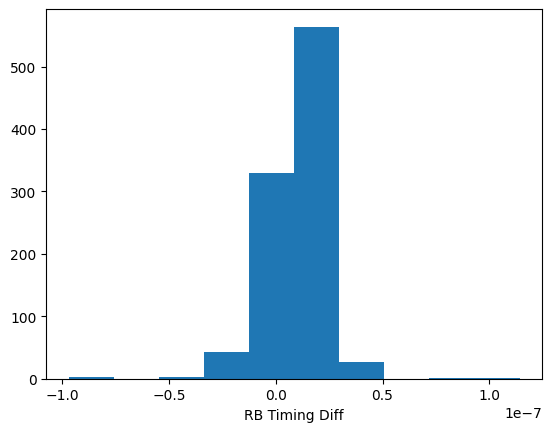

In [140]:
plt.hist(time_diff_dist, bins = 10)
plt.xlabel('RB Timing Diff')
plt.show()